In [ ]:
import sys
USING_COLAB = 'google.colab' in sys.modules

if USING_COLAB:
    !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
    !pip install -U renderlab
    !pip install -U colabgymrender
    !pip install -U moviepy==0.2.3.5
    !pip install imageio==2.4.1
    !pip install --upgrade AutoROM
    !AutoROM --accept-license
    !pip install gymnasium
    # !pip install gym[classic_control] > /dev/null 2>&1
    !pip install stable_baselines3

import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from copy import deepcopy
import torch.optim as optim #specific to ac

from torch.utils.data import DataLoader
from torch import nn
import torch
from gym import spaces

from __future__ import annotations

from collections import defaultdict

import seaborn as sns
from matplotlib.patches import Patch

from tqdm import tqdm, trange


seed = 4756
data_seed = 700

def reseed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

reseed(seed)

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.10/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [ ]:
def visualize(env_name="Blackjack-v1", algorithm=None, video_name="test", env_args={}):
    """Visualize a policy network for a given algorithm on a single episode

        Args:
            env_name: Name of the gym environment to roll out `algorithm` in, it will be instantiated using gym.make or make_vec_env
            algorithm (PPOActor): Actor whose policy network will be rolled out for the episode. If
            no algorithm is passed in, a random policy will be visualized.
            video_name (str): Name for the mp4 file of the episode that will be saved (omit .mp4). Only used
            when running on local machine.
    """

    def get_action(obs):
        if not algorithm:
            return env.action_space.sample()
        else:
            return algorithm.select_action(obs)

    if USING_COLAB:
        from renderlab import RenderFrame

        directory = './video'
        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        env = RenderFrame(env, directory)
        obs, info = env.reset()

        for i in range(200):
            action = get_action(obs)
            obs, reward, done, truncate, info = env.step(action)

            if done:
                break

        env.play()
    else:
        import cv2

        video = cv2.VideoWriter(f"{video_name}.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 24, (600,400))

        env_args['render_mode'] = 'rgb_array'
        env = gym.make(env_name, **env_args)
        obs, info = env.reset()

        for i in range(500):
            action = get_action(obs)
            res = env.step(action)
            obs, reward, done, truncate, info = res

            if done:
                break

            im = env.render()
            im = im[:,:,::-1]

            video.write(im)

        video.release()
        env.close()
        print(f"Video saved as {video_name}.mp4")

In [ ]:
visualize()

/usr/local/lib/python3.10/dist-packages/imageio/core/util.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/us

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int):
        """Policy network for the REINFORCE algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            action_dim (int): Dimension of the action space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(PolicyNet, self).__init__()
        # TODO: Implement the policy network for the REINFORCE algorithm here

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state: torch.Tensor):
        """Forward pass of the policy network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Probabilities of the actions.
        """
        # TODO: Implement the forward pass of the policy network here


        x = nn.functional.relu(self.fc1(state))
        x = nn.functional.softmax(self.fc2(x), dim= -1)
        return x

  and should_run_async(code)



In [ ]:
class PolicyGradient:
    def __init__(self, env, policy_net, seed, reward_to_go: bool = False):
        """Policy gradient algorithm based on the REINFORCE algorithm.

        Args:
            env (gym.Env): Environment
            policy_net (PolicyNet): Policy network
            seed (int): Seed
            reward_to_go (bool): True if using reward_to_go, False if not
        """
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net = policy_net.to(self.device)
        self.reward_to_go = reward_to_go
        # self.seed = seed
        # env.reset(seed=seed)
        # self.env.action_space.seed(self.seed)
        # self.env.observation_space.seed(self.seed)
        # torch.manual_seed(self.seed)
        # np.random.seed(self.seed)

        self.seed = seed
        # self.env.seed(self.seed)
        self.env.action_space.seed(self.seed)
        self.env.observation_space.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)


    def select_action(self, state):
        """Select an action based on the policy network

        Args:
            state (tuple): State of the environment with components:
                - player_sum (int): Player's current hand sum
                - dealer_card (int): Dealer's visible card
                - usable_ace (bool): Whether player has a usable ace

        Returns:
            action (int): Action to be taken
        """

        if isinstance(state[0], int):
            state_arr = [state[0], 0, 0]
        else:
            state_arr = np.array(state[0]).flatten()
            state_arr = [float(x) for x in state_arr]

        # state_tensor = torch.tensor(state_arr, dtype=torch.float32).unsqueeze(0)

        # state_arr = np.array(state[0], dtype=np.float32)  # Convert tuple to numpy array
        state_tensor = torch.tensor(state_arr, dtype=torch.float32).unsqueeze(0).to(self.device)

        # print(state_tensor)
        action_probs = self.policy_net(state_tensor)

        distribution = torch.distributions.Categorical(action_probs)
        action = distribution.sample()

        return int(action.item())


    def compute_loss(self, episode, gamma):
        """Compute the loss function for the REINFORCE algorithm

        Args:
            episode (list): List of tuples (state, action, reward)
            gamma (float): Discount factor

        Returns:
            loss (torch.Tensor): The value of the loss function
        """
        # TODO: Extract states, actions and rewards from the episode
        states = list(map(lambda x: x[0], episode))
        actions = list(map(lambda x: x[1], episode))
        rewards = list(map(lambda x: x[2], episode))

        if not self.reward_to_go:
            # TODO: Part 1: Compute the total discounted reward here
            disc_reward = 0
            for i in reversed(range(len(rewards))):
             # disc_reward += (gamma ** i) * rewards[i]
              disc_reward = rewards[i] + gamma * disc_reward


            total_reward = torch.tensor([disc_reward] * len(rewards), dtype=torch.float32)

        else:

            total_reward = []

            for t in range(len(rewards)):

                disc_reward = 0
                for i in range(t, len(rewards)):
                    disc_reward += (gamma ** (i - t)) * rewards[i]

                total_reward.append(disc_reward)
            total_reward = torch.tensor(total_reward, dtype=torch.float32)


        # TODO: Implement the loss function for the REINFORCE algorithm here
        # loss = None

        loss = torch.tensor(0.0, dtype=torch.float32)
        for i in range(len(rewards)):
            state_arr = states[i][0]
            float_state = [float(x) for x in state_arr]
            state = torch.tensor(state_arr, dtype=torch.float32) #.unsqueeze(0)
            actions_prob = self.policy_net(state)
            prob = actions_prob[actions[i]]
            log_prob = torch.log(prob)
            disc_return = total_reward[i]
            loss += (-log_prob * disc_return)

        # print(loss.grad_fn)

        # print("Loss" + str(loss))

        # loss = torch.tensor(loss, dtype=torch.float32)

        # print(loss.grad_fn)

        return loss

    def update_policy(self, episodes, optimizer, gamma):
        """Update the policy network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer
            gamma (float): Discount factor
        """
        # TODO: Compute the loss function for each episode using compute_loss

        optimizer.zero_grad()

        loss = 0

        for episode in episodes:
            loss += self.compute_loss(episode, gamma)

        loss = loss/len(episodes)

        # print("Loss: " + str(loss))

        loss.backward()
        optimizer.step()

    def run_episode(self):
        """
        Run an episode of the environment and return the episode

        Returns:
            episode (list): List of tuples (state, action, reward)
        """
        # env.reset(seed=seed)
        self.env.action_space.seed(seed)
        self.env.observation_space.seed(seed)
        state = self.env.reset()
        episode = []
        done = False
        while not done:
            action = self.select_action(state)
            next_state, reward, done, info, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def train(self, num_iterations, batch_size, gamma, lr):
        """Train the policy network using the REINFORCE algorithm

        Args:
            num_iterations (int): Number of iterations to train the policy network
            batch_size (int): Number of episodes per batch
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        self.policy_net.train()
        optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        # TODO: Implement the training loop for the REINFORCE algorithm here.
        # Update the policy every iteration, and use one batch per iteration.


        total_reward = torch.tensor(0.0, dtype=torch.float32)

        for i in range(num_iterations):
          rewards = []
          episodes = []

          for j in range(batch_size):
              episode = self.run_episode()
              episodes.append(episode)
          self.update_policy(episodes, optimizer, gamma)


          # total_reward = []

          if i%10 == 0:
            training_iterations.append(i)
            average_reward = self.evaluate(10)
            total_reward += average_reward
            print("Iteration " + str(i) + " " + str(average_reward))
            average_rewards_iterations.append(average_reward)


        return total_reward


    def evaluate(self, num_episodes = 100):
        """Evaluate the policy network by running multiple episodes.

        Args:
            num_episodes (int): Number of episodes to run

        Returns:
            average_reward (float): Average total reward per episode
        """
        self.policy_net.eval()
        # TODO: Implement an evaluation loop for the REINFORCE algorithm here
        # by running multiple episodes and returning the average total reward

        total_return = 0

        for i in range(num_episodes):
            episode = self.run_episode()


            episode_reward = 0
            for state, action, reward in episode:
                episode_reward += reward
            total_return += episode_reward


        average_reward = total_return / num_episodes

        return average_reward

Iteration 0 -0.3
Iteration 10 -0.8
Iteration 20 -0.4
Iteration 30 -0.1
Iteration 40 -0.3
Iteration 50 0.0
Iteration 60 -0.6
Iteration 70 -0.4
Iteration 80 -0.7
Iteration 90 -0.2
Iteration 100 0.0
Iteration 110 -0.4
Iteration 120 -0.1
Iteration 130 -0.4
Iteration 140 0.0
Iteration 150 0.0
Iteration 160 -0.1
Iteration 170 0.2
Iteration 180 -0.1
Iteration 190 0.2


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1733969317.81932.mp4, 900000 bytes wanted but 0 bytes read,at frame 2/3, at time 0.07/0.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 3/3 [00:00<00:00, 103.76it/s]


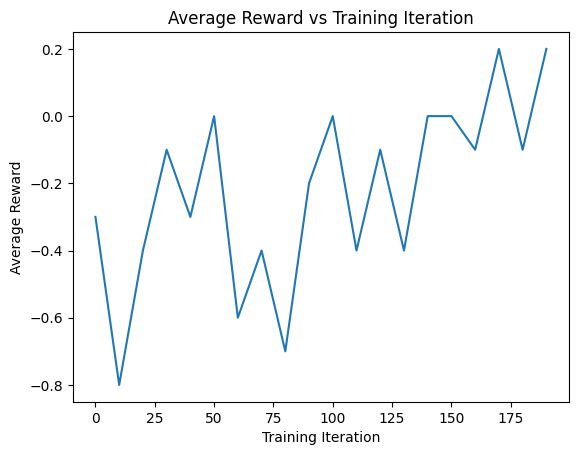

In [ ]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
env = gym.make("Blackjack-v1", sab=True)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

training_iterations = []
average_rewards_iterations = []

policy_net = PolicyNet(3, 1, 128)

reinforce = PolicyGradient(env, policy_net, seed, reward_to_go=False)
reinforce.train(num_iterations=200, batch_size=10, gamma=0.99, lr=0.001)

visualize(algorithm=reinforce, video_name="reinforce")

plt.plot(training_iterations, average_rewards_iterations)
plt.xlabel("Training Iteration")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Training Iteration")
plt.show()

In [ ]:
reinforce.evaluate(100)

  and should_run_async(code)



-0.25

Iteration 0 -0.3
Iteration 10 -0.4
Iteration 20 -0.4
Iteration 30 -0.5
Iteration 40 -0.5
Iteration 50 -0.3
Iteration 60 -0.6
Iteration 70 -0.5
Iteration 80 -0.4
Iteration 90 0.4
Iteration 100 0.4
Iteration 110 -0.8
Iteration 120 -0.1
Iteration 130 0.6
Iteration 140 -0.2
Iteration 150 -0.5
Iteration 160 -0.2
Iteration 170 -0.2
Iteration 180 -0.1
Iteration 190 0.0


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1733969753.1491282.mp4, 900000 bytes wanted but 0 bytes read,at frame 2/3, at time 0.07/0.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 3/3 [00:00<00:00, 111.12it/s]


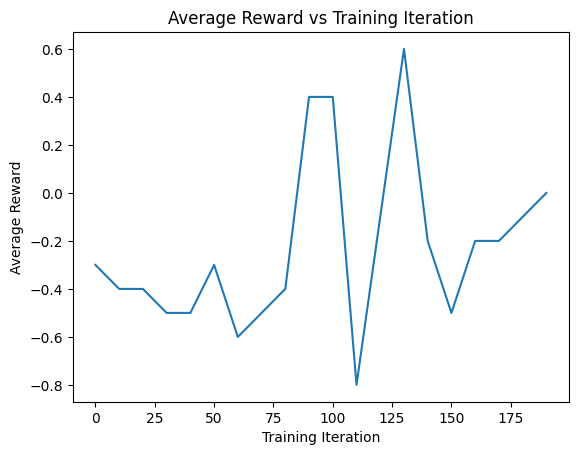

In [ ]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
env = gym.make("Blackjack-v1", sab=True)
reseed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
env.reset()

training_iterations = []
average_rewards_iterations = []

policy_net_rtg = PolicyNet(3, 1, 128)

reinforce_rtg = PolicyGradient(env, policy_net_rtg, seed, reward_to_go=True)
reinforce_rtg.train(num_iterations=200, batch_size=10, gamma=0.99, lr=0.001)

visualize(algorithm=reinforce_rtg, video_name="reinforce_rtg")

plt.plot(training_iterations, average_rewards_iterations)
plt.xlabel("Training Iteration")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Training Iteration")
plt.show()

In [ ]:
reinforce_rtg.evaluate(100)

-0.13

In [ ]:
class ValueNet(nn.Module):
    def __init__(self, state_dim: int, hidden_dim: int):
        """Value network for the Actor-Critic algorithm.

        Args:
            state_dim (int): Dimension of the state space.
            hidden_dim (int): Dimension of the hidden layers.
        """
        super(ValueNet, self).__init__()
        # TODO: Implement the value network for the A2C algorithm here

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, state: torch.Tensor):
        """Forward pass of the value network.

        Args:
            state (torch.Tensor): State of the environment.

        Returns:
            x (torch.Tensor): Estimated value of the state.
        """
        # TODO: Implement the forward pass for the value network here

        x = self.fc1(state)
        x = nn.functional.relu(self.fc2(x))
        return x


In [ ]:
class ActorCriticPolicyGradient(PolicyGradient):
    def __init__(self, env, policy_net, value_net, seed, reward_to_go: bool = True):
        """A2C algorithm.

        Args:
            env (gym.Env): Environment
            policy_net (PolicyNet): Policy network
            value_net (ValueNet): Value network
            seed (int): Seed
            reward_to_go (bool): Not used
        """
        self.env = env
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.policy_net = policy_net.to(self.device)
        self.value_net = value_net.to(self.device)
        # self.seed = seed
        # self.env.action_space.seed(self.seed)
        # self.env.observation_space.seed(self.seed)
        # torch.manual_seed(self.seed)
        # np.random.seed(self.seed)
        # env.reset(seed=seed)

        self.seed = seed
        self.env.action_space.seed(self.seed)
        self.env.observation_space.seed(self.seed)
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)




    def compute_loss(self, episode, gamma):
        """Compute the loss function for the A2C algorithm

        Args:
            episode (list): List of tuples (state, action, reward)

        Returns:
            policy_loss (torch.Tensor): Value of policy loss function
            value_loss (torch.Tensor): Value of value loss function
        """
        # TODO: Compute the policy loss and value loss for A2C

        states = list(map(lambda x: x[0], episode))
        actions = list(map(lambda x: x[1], episode))
        rewards = list(map(lambda x: x[2], episode))

        total_reward = []

        for t in range(len(rewards)): #reward-to-go
            disc_reward = 0
            for i in range(t, len(rewards)):
                disc_reward += (gamma ** (i - t)) * rewards[i]

            total_reward.append(disc_reward)

        total_reward = torch.tensor(total_reward)

        advantages = []
        for i in range(len(rewards)):
          state_arr = states[i][0]
          float_state = [float(x) for x in state_arr]
          state = torch.tensor(float_state)
          advantages.append(total_reward[i] - self.value_net(state))


        policy_loss = torch.tensor(0.0, dtype=torch.float32)
        for i in range(len(rewards)):
            state_arr = states[i][0]
            float_state = [float(x) for x in state_arr]
            state = torch.tensor(float_state)
            actions_prob = self.policy_net(state)
            prob = actions_prob[actions[i]]
            log_prob = torch.log(prob)
            policy_loss += (-log_prob * advantages[i][0])

        policy_loss = policy_loss/len(rewards)

        value_loss = torch.tensor(0.0, dtype=torch.float32)
        for i in range(len(advantages)):
          value_loss += (advantages[i][0] ** 2)

        value_loss = value_loss/len(rewards)

        return policy_loss, value_loss

    def update_policy(self, episodes, optimizer, value_optimizer, gamma):
        """Update the policy network and value network using the batch of episodes

        Args:
            episodes (list): List of episodes
            optimizer (torch.optim): Optimizer for policy network
            value_optimizer (torch.optim): Optimizer for value network
            gamma (float): Discount factor
        """
        # TODO: Compute the policy and value loss for each episode

        # TODO: Update the policy network and value network using average loss across the batch

        optimizer.zero_grad()
        value_optimizer.zero_grad()

        total_value_loss = torch.tensor(0.0, dtype=torch.float32)

        total_policy_loss = torch.tensor(0.0, dtype=torch.float32)

        for episode in episodes:
            policy_loss, value_loss = self.compute_loss(episode, gamma)

            total_policy_loss += policy_loss
            total_value_loss += value_loss

        total_policy_loss = total_policy_loss/len(episodes)
        total_value_loss = total_value_loss/len(episodes)

        total_policy_loss.backward(retain_graph=True)
        total_value_loss.backward()

        optimizer.step()
        value_optimizer.step()



    def train(self, num_iterations, batch_size, gamma, lr):
        """Train the policy network and value network using the A2C algorithm

        Args:
            num_iterations (int): Number of iterations to train the policy and value networks
            batch_size (int): Number of episodes per batch
            gamma (float): Discount factor
            lr (float): Learning rate
        """
        self.policy_net.train()
        optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=lr)
        value_optimizer = torch.optim.Adam(self.value_net.parameters(), lr=lr)
        # TODO: Implement the training loop for the A2C algorithm here.
        # Update the policy and value networks every iteration, and use one
        # batch per iteration.


        total_reward = torch.tensor(0.0, dtype=torch.float32)

        for i in range(num_iterations):
          rewards = []
          episodes = []

          for j in range(batch_size):
              episode = self.run_episode()
              episodes.append(episode)
          self.update_policy(episodes, optimizer, value_optimizer, gamma)


          # total_reward = []

          if i%10 == 0:
            training_iterations.append(i)
            average_reward = self.evaluate(10)
            total_reward += average_reward
            print("Iteration " + str(i) + " " + str(average_reward))
            average_rewards_iterations.append(average_reward)


        return total_reward

Iteration 0 -0.9
Iteration 10 -0.4
Iteration 20 -0.5
Iteration 30 0.0
Iteration 40 -0.4
Iteration 50 -0.1
Iteration 60 -0.4
Iteration 70 -0.5
Iteration 80 -0.1
Iteration 90 -0.2
Iteration 100 0.0
Iteration 110 -0.6
Iteration 120 0.3
Iteration 130 0.0
Iteration 140 0.1
Iteration 150 0.2
Iteration 160 0.0
Iteration 170 0.1
Iteration 180 0.0
Iteration 190 -0.5


  0%|          | 0/3 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1733969547.0590718.mp4, 900000 bytes wanted but 0 bytes read,at frame 2/3, at time 0.07/0.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

100%|██████████| 3/3 [00:00<00:00, 100.14it/s]


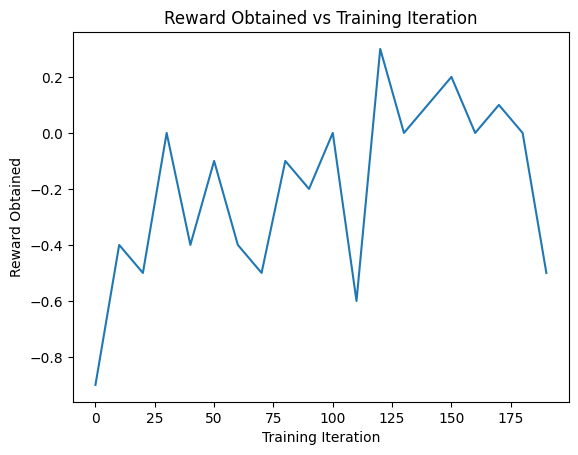

In [ ]:
# Feel free to use the space below to run experiments and create plots used in your writeup.
env = gym.make("Blackjack-v1", sab=True)
reseed(seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
env.reset()
# env.reset(seed=1000)

training_iterations = []
average_rewards_iterations = []


policy_net_a2c = PolicyNet(3,1, 128)
value_net = ValueNet(3, 128)

a2c = ActorCriticPolicyGradient(env, policy_net_a2c, value_net, seed)
a2c.train(num_iterations=200, batch_size=10, gamma=0.99, lr=0.01)

visualize(algorithm=a2c, video_name="a2c")

plt.plot(training_iterations, average_rewards_iterations)
plt.xlabel("Training Iteration")
plt.ylabel("Reward Obtained")
plt.title("Reward Obtained vs Training Iteration")
plt.show()

In [ ]:
reward = a2c.evaluate(num_episodes=100)
print(reward)

-0.1
